In [ ]:
# Author: Elahe Golrokh
# Repo: https://github.com/ElahehGolrokh/TMDB-5000-Movie-Dataset.git
# TODO: CONSIDER THE EFFECT OF DIRECTOR AND OTHER CREW

# **1- Importing Libararies**

In [ ]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()
%matplotlib inline

In [ ]:
import matplotlib as mpl
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud, STOPWORDS
from IPython.core.interactiveshell import InteractiveShell


# **2- Loading Data**

In [ ]:
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [ ]:
data_path = '/content/drive/MyDrive/archive.zip'

In [ ]:
!unzip -q $data_path

# **3- Feature Engineering**

In [ ]:
#___________________________
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________________
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']
#____________________________________
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
#_____________________________________________________
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}
#_____________________________________________________
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
#_____________________________________________________
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
#_____________________________________________________
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])
#_____________________________________________________
def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    tmdb_movies['production_companies'] = tmdb_movies['production_companies'].apply(pipe_flatten_names)
    tmdb_movies['production_countries'] = tmdb_movies['production_countries'].apply(pipe_flatten_names)
    return tmdb_movies

In [ ]:
# plt.rcParams["patch.force_edgecolor"] = True
# plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
# InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()
#__________________
# load the dataset
credits = load_tmdb_credits("/content/tmdb_5000_credits.csv")
movies = load_tmdb_movies("/content/tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)
#__________________________________________
# info on variable types and filling factor
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info.T

Shape: (4803, 26)


,column type,null values,null values (%)
budget,int64,0,0.0
genres,object,0,0.0
homepage,object,3091,64.355611
id,int64,0,0.0
plot_keywords,object,0,0.0
language,object,86,1.790548
original_title,object,0,0.0
overview,object,3,0.062461
popularity,float64,0,0.0
production_companies,object,0,0.0


In [ ]:
df_initial.shape

(4803, 26)

# **4- Data Cleaning**

In [ ]:
def remove_outliers(df, col, perc):
  q = df[col].quantile(perc)
  if perc > .5:
    df = df[df[col] < q]
  else:
    df = df[df[col] > q]
  return df

In [ ]:
def count_word(df, ref_col, liste):
    """
    This function deals with categorical columns with multi-categories
    mean genres, keywords and companies columns. It returns a list of
    lists in the example form of:
    >>> [['category_1', occurances],
        ['category_2', occurances]]
    """
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in [s for s in liste_keywords if s in liste]:
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences

In [ ]:
def generate_categorical_columns(df: pd.DataFrame,
                                 ref_col: str,
                                 col_name: str,
                                 keyword: str) -> pd.DataFrame:
  """
  Generates new categorical columns for each distinct categories
  in a complex column like genre in which there are plenty of
  categories dixtinguished by | or some other signs
  """
  df[col_name] = df[ref_col].apply(lambda x: 1 if keyword in x else 0)
  return df

In [ ]:
def superstar_count(*input_list):
  count = 0
  for el in input_list:
    if el in super_stars:
      count += 1
  return count

In [ ]:
# @title
super_stars = ['Robert De Niro', 'Jack Nicholson', 'Marlon Brando', 'Denzel Washington', 'Katharine Hepburn', 'Humphrey Bogart', 'Meryl Streep', 'Daniel Day-Lewis', 'Sidney Poitier', 'Clark Gable', 'Ingrid Bergman', 'Tom Hanks', 'Elizabeth Taylor', 'Bette Davis', 'Gregory Peck', 'Leonardo DiCaprio', 'Cate Blanchett', 'Audrey Hepburn', 'Spencer Tracy', 'Kate Winslet', 'Shah Rukh Khan', 'Viola Davis', 'Sophia Loren', 'Cary Grant', 'Vivien Leigh', 'Marilyn Monroe', 'Laurence Olivier', 'James Stewart', 'Steve McQueen', 'Diane Keaton', 'Julia Roberts', 'Jodie Foster', 'Judy Garland', 'Morgan Freeman', 'Paul Newman', 'Henry Fonda', 'Catherine Deneuve', 'Grace Kelly', 'Helen Mirren', 'James Cagney', 'Angela Bassett', 'Johnny Depp', 'Greta Garbo', 'Olivia de Havilland', 'Charles Chaplin', 'Setsuko Hara', 'Julie Andrews', 'Montgomery Clift', 'Isabelle Huppert', 'Al Pacino', 'Rita Hayworth', 'Halle Berry', 'James Dean', 'Kirk Douglas', 'Natalie Wood', 'Marcello Mastroianni', 'Joan Crawford', 'Harrison Ford', 'Susan Sarandon', 'Gene Kelly', 'Glenn Close', 'Joan Fontaine', 'Julianne Moore', 'Will Smith', 'Bruce Lee', 'Regina King', 'Angelina Jolie', 'John Wayne', 'Jane Fonda', 'Charlton Heston', 'Gary Cooper', 'Anthony Hopkins', 'Liv Ullmann', 'Natalie Portman', 'Gérard Depardieu', 'Forest Whitaker', 'Sandra Bullock', 'Deborah Kerr', 'Toshirô Mifune', 'Dustin Hoffman', 'Mohanlal', 'Emma Thompson', 'Tom Cruise', 'Michelle Pfeiffer', 'Faye Dunaway', 'Samuel L. Jackson', "Peter O'Toole", 'Heath Ledger', 'Penélope Cruz', 'Nicole Kidman', 'Chadwick Boseman', 'Antonio Banderas', 'Sigourney Weaver', 'Salma Hayek', 'Don Cheadle', 'Frances McDormand', 'Kathy Bates', 'Omar Sharif', 'Amy Adams', 'Joaquin Phoenix', 'Jeff Bridges', 'Ben Kingsley', 'Tommy Lee Jones', 'Robert Redford', 'Jack Lemmon', 'Christopher Plummer', 'George C. Scott', 'Robin Williams', 'Christopher Walken', 'Philip Seymour Hoffman', 'George Clooney', 'Gene Hackman', 'Bruce Willis', 'Sean Connery', 'Ian McKellen', 'Russell Crowe', 'Bill Murray', 'Nicolas Cage', 'Joe Pesci', 'Brad Pitt', 'Kevin Costner', 'Donald Sutherland', 'Clint Eastwood', 'Michael Douglas', 'Robert Downey Jr.', 'Ava Gardner', 'Sally Field', 'Doris Day', 'Shirley MacLaine', 'Holly Hunter', 'Hilary Swank', 'Claudette Colbert', 'Diane Lane', 'Jessica Lange', 'Gloria Swanson', 'Lauren Bacall', 'Lucy Liu', 'Norma Shearer', 'Bette Midler', 'Mary Tyler Moore', 'Anna Magnani', 'Judi Dench', 'Sharon Stone', 'Kim Basinger', 'Glenda Jackson', 'Donna Reed', 'Demi Moore', 'Anne Hathaway', 'Liza Minnelli', 'Geena Davis', 'Peter Sellers', 'Woody Allen', 'Mel Gibson', 'Jim Carrey', 'Mark Wahlberg', 'Steve Martin', 'Javier Bardem', 'Christoph Waltz', 'Tim Robbins', 'Arnold Schwarzenegger', 'Sylvester Stallone', 'Viggo Mortensen', 'Christopher Lee', 'Geoffrey Rush', 'Alec Guinness', 'Richard Burton', 'Alec Baldwin', 'James Caan', 'Chiwetel Ejiofor', 'Mads Mikkelsen', 'Ben Stiller', 'Willem Dafoe', 'Ed Harris', 'Harvey Keitel', 'Jon Voight', 'Drew Barrymore', 'Winona Ryder', 'Kathleen Turner', 'Uma Thurman', 'Rene Russo', 'Whoopi Goldberg', 'Annette Bening', 'Maggie Smith', 'Barbra Streisand', 'Jennifer Lawrence', 'Joanne Woodward', 'Mercedes McCambridge', 'Anjelica Huston', 'Dianne Wiest', 'Goldie Hawn', 'Claudia Cardinale', 'Gwyneth Paltrow', 'Charlize Theron', 'Debra Winger', 'Marion Cotillard', 'Christina Ricci', 'Juliette Binoche', 'Daryl Hannah', 'Shirley Booth', 'Reese Witherspoon', 'Benicio Del Toro', 'Kevin Bacon', 'Patrick Swayze', 'Michael Caine', 'Robert Duvall', 'Burt Lancaster', 'Robert Mitchum', 'Colin Farrell', 'William Holden', 'Edward G. Robinson', 'William Powell', 'Jared Leto', 'Errol Flynn', 'Groucho Marx', 'James Mason', 'Buster Keaton', 'Orson Welles', 'Fred Astaire', 'Bradley Cooper', 'Gary Oldman', 'Jude Law', 'Paul Giamatti', 'Liam Neeson', 'Matt Damon', 'Michael Fassbender', 'Carol Burnett', 'Jessica Tandy', 'Helen Hunt', 'Patricia Arquette', 'Carmen Miranda', 'Kate Hudson', 'Catherine Zeta-Jones', 'Cameron Diaz', 'Debbie Reynolds', 'Ellen Burstyn', "Maureen O'Hara", 'Myrna Loy', 'Lena Headey', 'Toni Collette', 'Laura Linney', 'Marlene Dietrich', 'Carole Lombard', 'Jean Arthur', 'Jean Harlow', 'Ginger Rogers', 'Mary Pickford', 'Mae West', 'Gillian Anderson', 'Emma Watson', 'Meg Ryan', 'Alan Arkin', 'Kurt Russell', 'Jake Gyllenhaal', 'Ryan Gosling', 'Colin Firth', 'Jamie Foxx', 'Adrien Brody', 'Roberto Benigni', 'Jeremy Irons', 'F. Murray Abraham', 'Richard Dreyfuss', 'Peter Finch', 'Art Carney', 'Cliff Robertson', 'Lee Marvin', 'Rex Harrison', 'Anthony Quinn', 'Maximilian Schell', 'Tom Hardy', 'David Niven', 'William Hurt', 'Yul Brynner', 'Ernest Borgnine', 'Benedict Cumberbatch', 'Rod Steiger', 'Chloë Grace Moretz', 'Anna Kendrick', 'Emily Watson', 'Helena Bonham Carter', 'Keira Knightley', 'Alexis Thorpe', 'Marion Davies', 'Scarlett Johansson', 'Dakota Fanning', 'Jennifer Aniston', 'Jennifer Connelly', 'Rachel McAdams', 'Carey Mulligan', 'Mila Kunis', 'Amanda Seyfried', 'Jennifer Lopez', 'Neve Campbell', 'Fairuza Balk', 'Jessica Alba', 'Kristen Stewart', 'Julie Walters', 'Rooney Mara', 'Jamie Lee Curtis', 'Emma Stone', 'Kirsten Dunst', 'José Ferrer', 'Broderick Crawford', 'Ronald Colman', 'Fredric March', 'Ray Milland', 'Bing Crosby', 'Paul Lukas', 'Robert Donat', 'Paul Muni', 'Victor McLaglen', 'Charles Laughton', 'Wallace Beery', 'Lionel Barrymore', 'Jeff Goldblum', 'Chris Hemsworth', 'Warner Baxter', 'Emil Jannings', 'Chris Cooper', 'Jim Broadbent', 'James Coburn', 'Cuba Gooding Jr.', 'Martin Landau', 'Jack Palance', 'Kevin Kline', 'Don Ameche', 'Kate Beckinsale', 'Zooey Deschanel', 'Michelle Williams', 'Milla Jovovich', 'Selena Gomez', 'Rachel Weisz', 'Kristen Bell', 'Katherine Heigl', 'Liv Tyler', 'Jessica Chastain', 'Megan Fox', 'Betty White', 'Geraldine Page', 'Eliza Dushku', 'Robin Wright', 'Leighton Meester', 'Jennifer Jones', 'Shirley Temple', 'Julia Louis-Dreyfus', 'Olivia Thirlby', 'Cher', 'Sissy Spacek', 'Louise Fletcher', 'Julie Christie', 'Patricia Neal', 'Haing S. Ngor', 'Louis Gossett Jr.', 'John Gielgud', 'Timothy Hutton', 'Melvyn Douglas', 'Jason Robards', 'George Burns', 'Christian Bale', 'Ethan Hawke', 'Ben Johnson', 'John Mills', 'Jack Albertson', 'Sean Penn', 'George Kennedy', 'Walter Matthau', 'Martin Balsam', 'Peter Ustinov', 'Ed Begley', 'George Chakiris', 'Hugh Griffith', 'Burl Ives', 'Red Buttons', "Edmond O'Brien", 'Chris Pratt', 'Frank Sinatra', 'Anne Bancroft', 'Kim Novak', 'Simone Signoret', 'Elliot Page', 'Angela Lansbury', 'Judy Holliday', 'Loretta Young', 'Shirley Jones', 'Vera Farmiga', 'Helen Hayes', 'Marie Dressler', 'Janet Gaynor', "Lupita Nyong'o", 'Octavia Spencer', 'Melissa Leo', "Mo'Nique", 'Marlee Matlin', 'Tilda Swinton', 'Jennifer Hudson', 'Renée Zellweger', 'Marcia Gay Harden', 'Anna Paquin', 'Marisa Tomei', 'Mercedes Ruehl', 'Brenda Fricker', 'Jean Reno', 'George Sanders', 'Dean Jagger', 'Walter Huston', 'Edmund Gwenn', 'Harold Russell', 'Hugh Grant', 'Barry Fitzgerald', 'Charles Coburn', 'Van Heflin', 'Donald Crisp', 'Thomas Mitchell', 'Walter Brennan', 'Joseph Schildkraut', 'Keanu Reeves', 'Channing Tatum', 'Hugh Jackman', 'Dwayne Johnson', 'Adam Sandler', 'Daniel Radcliffe', 'Daniel Craig', 'Henry Cavill', 'Vin Diesel', 'Ben Affleck', 'Chris Pine', 'Olympia Dukakis', 'Peggy Ashcroft', 'Linda Hunt', 'Maureen Stapleton', 'Mary Steenburgen', 'Beatrice Straight', 'Vanessa Redgrave', 'Lee Grant', 'Eileen Heckart', 'Cloris Leachman', 'Ruth Gordon', 'Estelle Parsons', 'Sandy Dennis', 'Shelley Winters', 'Maggie Gyllenhaal', 'Katie Holmes', 'Patty Duke', 'Rita Moreno', 'Wendy Hiller', 'Miyoshi Umeki', 'Dorothy Malone', 'Jo Van Fleet', 'Eva Marie Saint', 'Gloria Grahame', 'Kim Hunter', 'Lee J. Cobb', 'Andrew Garfield', 'John Cazale', 'Jeremy Renner', 'Steve Carell', 'Jean Dujardin', 'Chris Evans', 'James Franco', 'Zach Galifianakis', 'Will Ferrell', 'Shia LaBeouf', 'Seth Rogen', 'Joseph Gordon-Levitt', 'Ryan Reynolds', 'Paul Rudd', 'Jason Segel', 'Jason Statham', 'Dick Van Dyke', 'Jesse Eisenberg', 'Owen Wilson', 'Jason Bateman', 'Tyler Perry', 'Liam Hemsworth', 'William Shatner', 'Gene Wilder', 'Thora Birch', 'Claire Trevor', 'Celeste Holm', 'Anne Baxter', 'Queen Latifah', 'Ethel Barrymore', 'Rosario Dawson', 'Teresa Wright', 'Mary Astor', 'Jane Darwell', 'Alicia Vikander', 'Mia Wasikowska', 'Abigail Breslin', 'Gale Sondergaard', 'Melissa McCarthy', 'Tina Fey', 'Zoe Saldana', 'Elisabeth Moss', 'Adrianne Palicki', 'Jennifer Garner', 'Kristen Wiig', 'June Squibb', 'Sally Hawkins', 'Kaley Cuoco', 'Naomi Watts', 'Robert Pattinson', 'Charlie Hunnam', 'Nicholas Hoult', 'Aaron Taylor-Johnson', 'Bryan Cranston', 'Gerard Butler', 'Paul Walker', 'Karl Urban', 'Logan Lerman', 'Dave Franco', 'Tom Hiddleston', 'Peter Dinklage', 'Taylor Kitsch', 'Edward Norton', 'Guy Pearce', 'Mark Ruffalo', 'Mickey Rourke', 'Frank Langella', 'Eddie Redmayne', 'David Strathairn', 'Terrence Howard', 'Ralph Fiennes', 'Tom Wilkinson', 'Richard Farnsworth', 'Nick Nolte', 'AnnaSophia Robb', 'Gemma Arterton', 'Olivia Wilde', 'Isla Fisher', 'Shailene Woodley', 'Rebel Wilson', 'Emma Roberts', 'Amber Heard', 'Teresa Palmer', 'Saoirse Ronan', 'Elizabeth Banks', 'Ida Lupino', 'Natalie Dormer', 'Brittany Snow', 'Kate Mara', 'Julianne Hough', 'Lily Collins', 'Cobie Smulders', 'Alice Eve', 'Jamie Chung', 'Noomi Rapace', 'Blake Lively', 'Maggie Grace', 'Jessica Biel', 'Eva Green', 'Peter Fonda', 'Woody Harrelson', 'Billy Bob Thornton', 'Idris Elba', 'Nigel Hawthorne', 'Laurence Fishburne', 'Stephen Rea', 'Warren Beatty', 'Richard Harris', 'John Cusack', 'Kenneth Branagh', 'Edward James Olmos', 'Max von Sydow', 'Bruce Dern', 'Bob Hoskins', 'James Woods', 'John Hawkes', 'James Garner', 'Sam Waterston', 'Tom Hulce', 'Albert Finney', 'Tom Conti', 'Tom Courtenay', 'Dudley Moore', 'John Hurt', 'Kat Dennings', 'Priyanka Chopra Jonas', 'Emmanuelle Riva', 'Greta Gerwig', 'Brie Larson', 'Jessica Lucas', 'Maria Falconetti', 'Greer Garson', 'Rosalind Russell', 'Raquel Welch', 'Linda Fiorentino', 'Gabourey Sidibe', 'Judy Davis', 'Mia Farrow', 'Audrey Tautou', 'Jeanne Moreau', 'Jane Wyman', 'Gena Rowlands', 'Lesley Manville', 'Elizabeth Olsen', 'Nastassja Kinski', 'Mélanie Laurent', 'Whitney Houston', 'Felicity Huffman', 'Imelda Staunton', 'Oscar Isaac', 'Jon Heder', 'Miles Teller', 'Daniel Brühl', 'James Gandolfini', 'Michael B. Jordan', 'Anthony Perkins', 'David Thewlis', 'Klaus Kinski', 'Malcolm McDowell', 'Ray Winstone', 'Jean-Paul Belmondo', 'Andy Serkis', 'Matthew Broderick', 'Dennis Hopper', 'Michael Rooker', 'Vincent Gallo', 'Kevin Spacey', 'Vincent Cassel', 'J.K. Simmons', 'Boris Karloff', 'Peter Lorre', 'Matthew McConaughey', 'Paddy Considine', 'Ryan Phillippe', 'Kerry Washington', 'Carrie-Anne Moss', 'Janet Leigh', 'Catalina Sandino Moreno', 'Samantha Morton', 'Keisha Castle-Hughes', 'Barbara Stanwyck', 'Joan Allen', 'Janet McTeer', 'Fernanda Montenegro', 'Kristin Scott Thomas', 'Brenda Blethyn', 'Elisabeth Shue', 'Miranda Richardson', 'Stockard Channing', 'Luise Rainer', 'Mary McDonnell', 'Lucille Ball', 'Laura Dern', 'Pauline Collins', 'Isabelle Adjani', 'Melanie Griffith', 'Sally Kirkland', 'Jane Alexander', 'Marsha Mason', 'Freddie Highmore', 'Michael J. Fox', 'John Travolta', 'Chow Yun-Fat', 'Seth MacFarlane', 'Jet Li', 'John Houseman', 'Chuck Norris', 'Jean-Claude Van Damme', 'Sam Rockwell', 'Takashi Shimura', 'Richard E. Grant', 'Leslie Nielsen', 'Simon Pegg', 'John Malkovich', 'Michael Shannon', 'Martin Sheen', 'Christopher Guest', 'Alan Rickman', 'Jackie Earle Haley', 'Gig Young', 'James Spader', 'Eric Bana', 'Romain Duris', 'Robert Shaw', 'Jacki Weaver', 'Bérénice Bejo', 'Hailee Steinfeld', 'Jennifer Jason Leigh', 'Kathleen Quinlan', 'Taraji P. Henson', 'Amy Ryan', 'Ruby Dee', 'Jill Clayburgh', 'Adriana Barraza', 'Rinko Kikuchi', 'Catherine Keener', 'Charlotte Rampling', 'Sophie Okonedo', 'Patricia Clarkson', 'Shohreh Aghdashloo', 'Lindsay Lohan', 'Michelle Trachtenberg', 'Chloë Sevigny', 'Lynn Redgrave', 'Rachel Griffiths', 'Margot Robbie', 'Lili Taylor', 'Robin Weigert', 'Lake Bell', 'Claude Rains', 'Steve Buscemi', 'John Rhys-Davies', 'Jean-Louis Trintignant', 'Joseph Cotten', 'Barry Pepper', 'Erich von Stroheim', 'Patrick Wilson', 'Christopher Lloyd', 'Ben Foster', 'Joel McCrea', 'Choi Min-sik', 'Ewan McGregor', 'Gael García Bernal', 'Bruno Ganz', 'Sean Astin', 'Irrfan Khan', 'Michael C. Hall', 'Roy Scheider', 'Casey Affleck', 'Gary Busey', 'Norman Reedus', 'Jeff Daniels', 'Stanley Tucci', 'Kiefer Sutherland', 'Michelle Yeoh', 'Léa Seydoux', 'Dakota Johnson', 'Julie Delpy', 'Linda Hamilton', 'Carrie Fisher', 'Pam Grier', 'Björk', 'Emily Browning', 'Juliette Lewis', 'Sarah Jessica Parker', 'Piper Laurie', 'Miley Cyrus', 'Lily Tomlin', 'Jane Seymour', 'Gloria Stuart', 'Talia Shire', 'Gal Gadot', 'Sue Lyon', 'Olivia Newton-John', 'Minnie Driver', 'Teri Garr', 'Keri Russell', 'Jean Seberg', 'Sarah Polley', 'Josh Brolin', 'Hal Holbrook', 'Djimon Hounsou', 'Matt Dillon', 'Alan Alda', 'Thomas Haden Church', 'Clive Owen', 'Ken Watanabe', 'Suraj Sharma', 'John C. Reilly', 'Michael Clarke Duncan', 'Haley Joel Osment', 'Greg Kinnear', 'Burt Reynolds', 'Robert Forster', 'Jason Schwartzman', 'William H. Macy', 'Armin Mueller-Stahl', 'Tim Roth', 'James Cromwell', 'Chazz Palminteri', 'Gary Sinise', 'Paul Scofield', 'Pete Postlethwaite', 'Hugo Weaving', 'Jada Pinkett Smith', "Tatum O'Neal", 'Anna Faris', 'Hattie McDaniel', 'Famke Janssen', 'Rosamund Pike', 'Bonnie Hunt', 'Leslie Mann', 'Mindy Kaling', 'Thandiwe Newton', 'Amy Poehler', 'Amanda Peet', 'Julia Stiles', 'Maria Bello', 'Eva Mendes', 'Emily Blunt', 'Rose Byrne', 'Ashley Judd', 'Emilia Clarke', 'Christina Applegate', 'Nia Long', 'Felicity Jones', 'Téa Leoni', 'Alexandra Daddario', 'Jena Malone', 'Richard Gere', 'Nick Frost', 'Ray Liotta', 'Chris Rock', 'Jon Hamm', 'Neil Patrick Harris', 'Charlie Sheen', 'Mark Rylance', 'Andy Garcia', 'Michael Lerner', 'Graham Greene', 'Bruce Davison', 'Dan Aykroyd', 'Danny Aiello', 'River Phoenix', 'Dean Stockwell', 'Billy Crystal', 'John Goodman', 'Orlando Bloom', 'Stellan Skarsgård', 'Alexander Skarsgård', 'Mike Myers', 'Tyrese Gibson', 'Elijah Wood', 'Danny DeVito', 'Susan Hayward', 'Michelle Rodriguez', 'Sarah Michelle Gellar', 'Sandra Oh', 'Margot Kidder', 'Beyoncé', 'Rebecca Hall', 'Piper Perabo', 'Courteney Cox', 'Parker Posey', 'Paula Patton', 'Michelle Monaghan', 'Claire Danes', 'Allison Janney', 'Kate Bosworth', 'Evan Rachel Wood', 'Mira Sorvino', 'Ziyi Zhang', 'Amanda Bynes', 'Lisa Kudrow', 'Brit Marling', 'Cynthia Erivo', 'Sofía Vergara', 'Mandy Moore', 'Virginia Madsen', 'James Marsden', 'Tim Allen', 'Giovanni Ribisi', 'Rutger Hauer', 'Vince Vaughn', 'Brian Cox', 'Dennis Quaid', 'John Leguizamo', 'Michael Keaton', 'Billy Burke', 'Brendan Gleeson', 'Charles Bronson', 'Jonathan Pryce', 'Tobey Maguire', 'Michael Sheen', 'Justin Long', 'Jack Black', 'Mel Brooks', 'Pierce Brosnan', 'Sean Bean', 'Mahershala Ali', 'Josh Duhamel', 'Eddie Murphy', 'Jon Favreau', 'Danny Glover', 'Freida Pinto', 'Hilary Duff', 'Mary Elizabeth Winstead', 'Jennifer Coolidge', 'Andrea Riseborough', 'Molly Ringwald', 'January Jones', 'Maya Rudolph', 'Sophie Marceau', 'Franka Potente', 'Claire Foy', 'Rashida Jones', 'Alicia Silverstone', 'Lillian Gish', 'Evangeline Lilly', 'Olivia Colman', 'Mireille Enos', 'Jennifer Love Hewitt', 'Emmy Rossum', 'Joey King', 'Ginnifer Goodwin', 'Christine Taylor', 'Vanessa Hudgens', 'Abbie Cornish', 'Florence Pugh', 'Ian Holm', 'Nathan Lane', 'Cary Elwes', 'Martin Lawrence', 'Steve Coogan', 'Sacha Baron Cohen', 'Jeffrey Wright', 'Jackie Chan', 'Aaron Eckhart', 'Sam Worthington', 'Jack Davenport', 'Alfred Molina', 'Tim Curry', 'Mark Hamill', 'Brendan Fraser', 'Ice Cube', 'Liev Schreiber', 'Ed Helms', 'Val Kilmer', 'Russell Brand', 'Craig T. Nelson', 'Bernie Mac', 'Patrick Stewart', 'Seth Green', 'Ashton Kutcher', 'Randy Quaid', 'Wesley Snipes', 'David Oyelowo', 'Mark Strong', 'Rob Schneider', 'Jay Baruchel', 'Hayden Christensen', 'Ray Stevenson', 'Paul Bettany', 'Hugh Laurie', 'Chris Tucker', 'John Candy', 'Richard Attenborough', "Chris O'Donnell", 'Benjamin Bratt', 'Common', 'Marlon Wayans', 'Albert Brooks', 'Aaron Paul', 'Macaulay Culkin', 'Sam Elliott', 'Taron Egerton', 'Jim Caviezel', 'Elvis Presley', 'Jonah Hill', 'Sung Kang', 'Jason Sudeikis', 'Josh Hartnett', 'Cillian Murphy', 'Billy Crudup', 'Anthony Mackie', 'John Barrymore', 'Timothy Olyphant', 'Josh Gad', 'Billy Zane', 'Luke Wilson', 'Peter Sarsgaard', 'Rhys Ifans', 'Topher Grace', 'Kevin Hart', 'Paul Dano', 'Bill Hader', 'Rob Lowe', 'Mel Blanc', 'David Spade', 'Rob Riggle', 'Lance Henriksen', 'Richard Jenkins', 'Emilio Estevez', 'Michael Ealy', 'Jamie Bell', 'Troy Baker', 'Danny McBride', 'Jonathan Rhys Meyers', 'Michael Cera', 'Bill Paxton', 'Ioan Gruffudd', 'Andrew Lincoln', 'Ezra Miller', 'Bill Pullman', 'Craig Robinson', 'Charlie Day', 'Andy Samberg', 'Garrett Hedlund', 'Cam Gigandet', 'John Krasinski', 'Kevin James', 'Christopher Reeve', 'James McAvoy', 'Rufus Sewell', 'Adam Driver', 'Ned Beatty', 'John Cleese', 'John Turturro', 'Jerry Lewis']

In [ ]:
# 1- Dealing with nans and not informative categories
df_remove_nan = df_initial.copy()
df_remove_nan['release_date'] = pd.to_datetime(df_remove_nan['release_date'])
# df_remove_nan['release_year'] = df_remove_nan['release_date'].apply(lambda x: x.year)
df_remove_nan['release_month'] = df_remove_nan['release_date'].apply(lambda x: x.month)
df_remove_nan.drop(['tagline', 'homepage', 'overview', 'status', 'original_title',
                    'title_year', 'release_date', 'id', 'production_countries',
                    'spoken_languages', 'language', 'production_companies',
                    'plot_keywords', 'movie_title', 'director_name', 'popularity',
                    'vote_average', 'num_voted_users'], axis=1, inplace=True)
df_remove_nan.dropna(inplace=True)

# 2- Removing outliers
numerical_columns = ['budget', 'duration']
categorical_columns = ['genres', 'country', 'release_month']
df_remove_outliers = df_remove_nan.copy()
print(f'df shape before removing outliers: {df_remove_outliers.shape}')
for col in numerical_columns:
    df_remove_outliers = remove_outliers(df_remove_outliers, col, .99)
print(f'df shape after removing outliers: {df_remove_outliers.shape}')

# 3- Dealing with categorical columns
df_categorical = df_remove_outliers.copy()
df_categorical['release_month'] = df_categorical['release_month'].apply(lambda x: 'first_half' if x <= 6 else 'second_half')

# 3-1- categorical columns with multi-categories; genres, keywords and companies
set_keywords = set()
for liste_keywords in df_categorical['genres'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)

keyword_occurences = count_word(df_categorical, 'genres', set_keywords)

df_categorical['genres'] = df_categorical['genres'].apply(lambda x: np.nan if x=='' else x)
df_categorical.dropna(subset=["genres"], inplace=True)

for genre in keyword_occurences:
  genre_labels = genre[0]
  occurances = genre[1]
  if occurances > 500:
    col_name = 'genre_' + genre_labels.replace(' ', '_')
    df_categorical = generate_categorical_columns(df=df_categorical,
                                          ref_col='genres',
                                          col_name=col_name,
                                          keyword=genre_labels)
df_categorical.drop('genres', axis=1, inplace=True)
df_cleaned = df_categorical.copy()
df_cleaned['super_stars'] = df_cleaned[['actor_1_name',
                                        'actor_2_name',
                                        'actor_3_name']].apply(lambda x: superstar_count(*x),
                                                               axis=1)
df_cleaned['country'] = df_cleaned['country'].apply(lambda x: 'USA' if x == 'United States of America' else 'Not USA')

df_cleaned.drop(['actor_1_name', 'actor_2_name',
                 'actor_3_name', ], axis=1, inplace=True)
df_cleaned.shape

df shape before removing outliers: (4573, 9)
df shape after removing outliers: (4479, 9)


(4474, 14)

# **Modeling**

<Axes: >

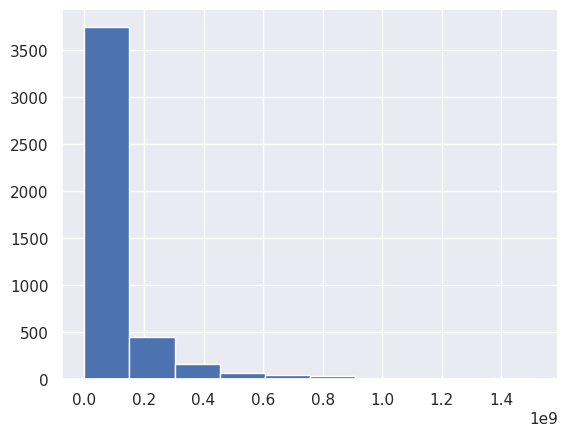

In [ ]:
df_cleaned['gross'].hist()

We define the profitable feature as a categorical target for the classification part of this project. <br>
Based on the gross histogram, we consider the movie profitable if the gross >= 10000000 and else it would not be profitable.

<Axes: xlabel='profitable', ylabel='count'>

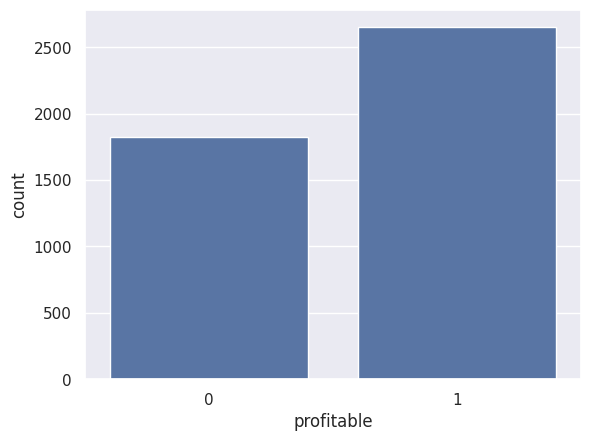

In [ ]:
# df_cleaned['profitable'] = df_cleaned['gross'].apply(lambda x: 0 if x == 0 else 1)
df_cleaned['profitable'] = df_cleaned['gross'].apply(lambda x: 0 if x < 10000000 else 1)
sns.countplot(data=df_cleaned, x='profitable')

In [ ]:
df_cleaned['profitable'].value_counts()

1    2650
0    1824
Name: profitable, dtype: int64

In [ ]:
final_df = df_cleaned.copy()
final_df = pd.get_dummies(final_df, drop_first=True)
final_df

,budget,gross,duration,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,genre_Science_Fiction,super_stars,profitable,country_USA,release_month_second_half
23,180000000,372234864,113.0,0,0,0,0,0,1,0,0,3,1,0,1
28,150000000,1513528810,124.0,0,0,1,1,0,1,0,1,1,1,1,0
35,150000000,836297228,150.0,0,0,0,1,0,1,0,1,2,1,1,0
39,170000000,400062763,125.0,0,0,0,1,0,1,0,1,2,1,1,1
44,190000000,1506249360,137.0,0,0,0,1,0,0,0,0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0,0,98.0,1,0,0,0,0,0,0,0,0,0,1,1
4796,7000,424760,77.0,1,0,1,0,0,0,0,1,0,0,1,1
4798,220000,2040920,81.0,0,0,1,1,0,0,1,0,0,0,0,1
4800,0,0,120.0,1,1,0,0,1,0,0,0,0,0,1,1


<Axes: >

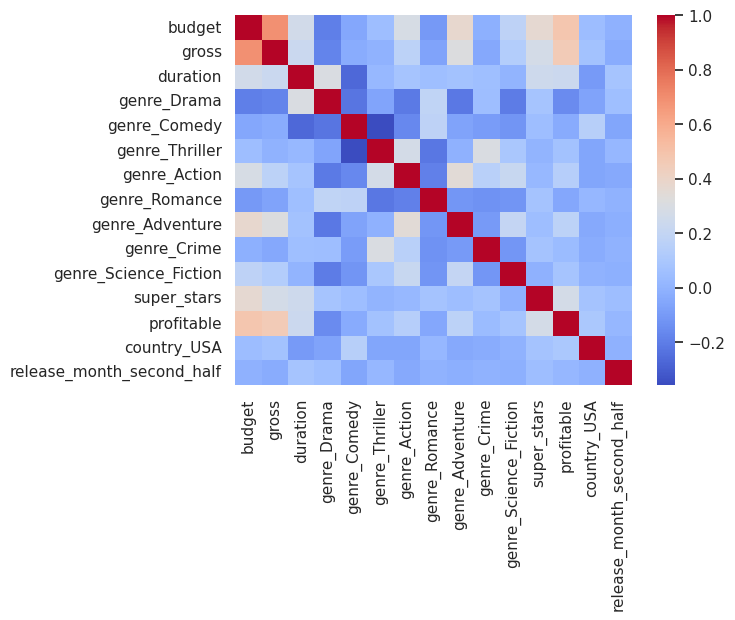

In [ ]:
sns.heatmap(final_df.corr(), cmap='coolwarm')

In [ ]:
final_df.columns

Index(['budget', 'gross', 'duration', 'genre_Drama', 'genre_Comedy',
       'genre_Thriller', 'genre_Action', 'genre_Romance', 'genre_Adventure',
       'genre_Crime', 'genre_Science_Fiction', 'super_stars', 'profitable',
       'country_USA', 'release_month_second_half'],
      dtype='object')

We consider profitable column as target. As a future task, one can repeat the modeling phase with either of popularity, gross, vote_average or num_voted_users columns.

In [ ]:
final_df = final_df[['budget', 'duration', 'genre_Drama', 'genre_Comedy', 'genre_Thriller',
                     'genre_Action', 'genre_Romance', 'genre_Crime', 'genre_Adventure',
                     'super_stars', 'profitable', 'country_USA',
                     'release_month_second_half']]

## **Standardization**

In [ ]:
categorical_df = final_df[['genre_Drama', 'genre_Comedy', 'genre_Thriller',
                           'genre_Action', 'genre_Romance', 'genre_Crime', 'genre_Adventure',
                           'country_USA', 'release_month_second_half']]
numerical_df = final_df[['budget', 'duration', 'super_stars']]

In [ ]:
categorical_df.set_index(np.arange(len(categorical_df)), inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
scalar.fit(numerical_df)
scaled_inputs = scalar.transform(numerical_df)

In [ ]:
scaled_df = pd.DataFrame(scaled_inputs, columns=numerical_df.columns)
scaled_df = pd.concat([scaled_df, categorical_df], axis=1)
scaled_df

,budget,duration,super_stars,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,country_USA,release_month_second_half
0,4.206165,0.347822,1.832827,0,0,0,0,0,0,1,0,1
1,3.373940,0.948716,-0.096147,0,0,1,1,0,0,1,1,0
2,3.373940,2.369013,0.868340,0,0,0,1,0,0,1,1,0
3,3.928757,1.003343,0.868340,0,0,0,1,0,0,1,1,1
4,4.483573,1.658865,1.832827,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4469,-0.787181,-0.471580,-1.060634,1,0,0,0,0,0,0,1,1
4470,-0.786987,-1.618743,-1.060634,1,0,1,0,0,0,0,1,1
4471,-0.781078,-1.400236,-1.060634,0,0,1,1,0,1,0,0,1
4472,-0.787181,0.730209,-1.060634,1,1,0,0,1,0,0,1,1


In [ ]:
inputs = scaled_df
target = final_df['profitable']

## **Train and Test**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=325)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3579, 12), (895, 12), (3579,), (895,))

## **Training and Evaluation**

### **1- Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [ ]:
predictions = model.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       361
           1       0.86      0.81      0.84       534

    accuracy                           0.81       895
   macro avg       0.80      0.81      0.81       895
weighted avg       0.81      0.81      0.81       895

[[291  70]
 [100 434]]


<Axes: >

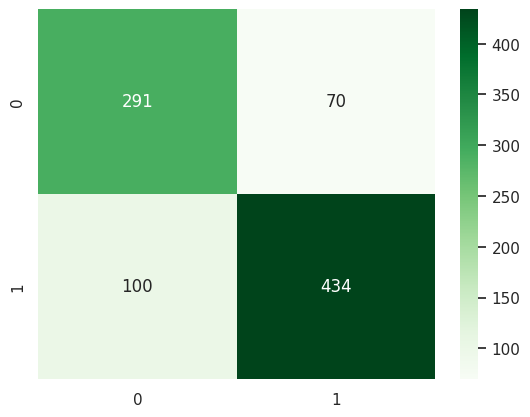

In [ ]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='0.0f')

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
## Accuracy
print('Accuracy = ', accuracy_score(y_test,predictions))
## Precision
print('Precision = ', precision_score(y_test,predictions))
## Recall
print('Recall = ', recall_score(y_test,predictions))
## F1 Score
print('F1_Score = ', f1_score(y_test,predictions))

Accuracy =  0.8100558659217877
Precision =  0.8611111111111112
Recall =  0.8127340823970037
F1_Score =  0.836223506743738


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate (FPR)
# and true positive rate (TPR) for different classification thresholds

y_pred_prob = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
roc_auc

0.878308278087294

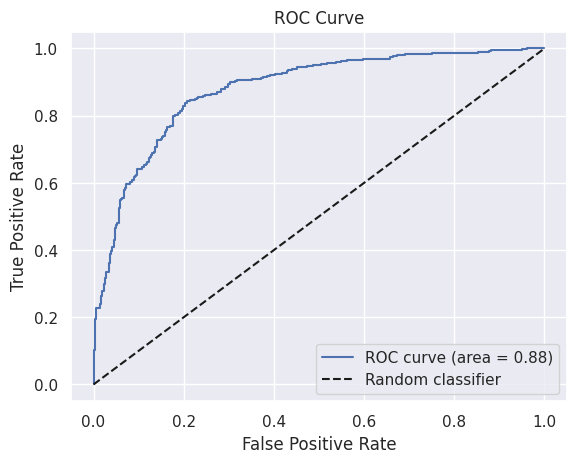

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### **2- Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(x_train,y_train)

DecisionTreeClassifier()

In [ ]:
predictions = dtree.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       361
           1       0.79      0.78      0.78       534

    accuracy                           0.74       895
   macro avg       0.73      0.73      0.73       895
weighted avg       0.74      0.74      0.74       895

[[247 114]
 [116 418]]


<Axes: >

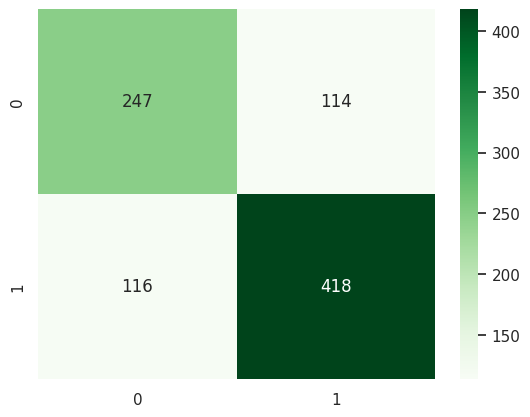

In [ ]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='0.0f')

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
## Accuracy
print('Accuracy = ', accuracy_score(y_test,predictions))
## Precision
print('Precision = ', precision_score(y_test,predictions))
## Recall
print('Recall = ', recall_score(y_test,predictions))
## F1 Score
print('F1_Score = ', f1_score(y_test,predictions))

Accuracy =  0.7430167597765364
Precision =  0.7857142857142857
Recall =  0.7827715355805244
F1_Score =  0.7842401500938087


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate (FPR)
# and true positive rate (TPR) for different classification thresholds

y_pred_prob = dtree.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
roc_auc

0.7334910309481568

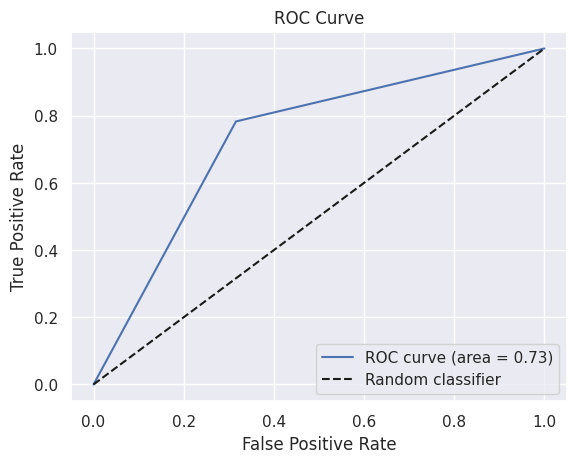

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### **3- Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
predictions = rfc.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       361
           1       0.81      0.87      0.84       534

    accuracy                           0.80       895
   macro avg       0.79      0.78      0.79       895
weighted avg       0.80      0.80      0.80       895

[[252 109]
 [ 71 463]]


<Axes: >

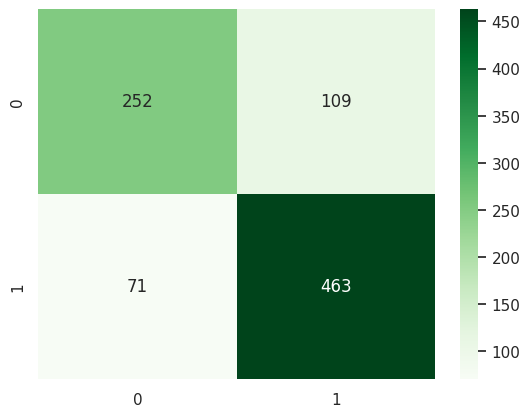

In [ ]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='0.0f')

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
## Accuracy
print('Accuracy = ', accuracy_score(y_test,predictions))
## Precision
print('Precision = ', precision_score(y_test,predictions))
## Recall
print('Recall = ', recall_score(y_test,predictions))
## F1 Score
print('F1_Score = ', f1_score(y_test,predictions))

Accuracy =  0.7988826815642458
Precision =  0.8094405594405595
Recall =  0.8670411985018727
F1_Score =  0.8372513562386981


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate (FPR)
# and true positive rate (TPR) for different classification thresholds

y_pred_prob = rfc.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
roc_auc

0.8679386224283357

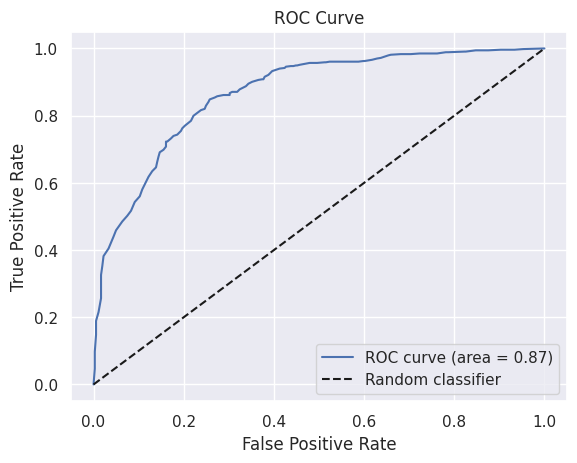

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### **4- XGBoost**

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75       361
           1       0.82      0.87      0.84       534

    accuracy                           0.81       895
   macro avg       0.80      0.79      0.80       895
weighted avg       0.81      0.81      0.80       895

[[257 104]
 [ 69 465]]


<Axes: >

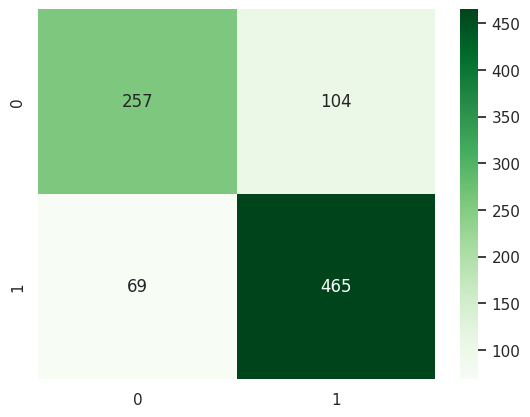

In [ ]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='0.0f')

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
## Accuracy
print('Accuracy = ', accuracy_score(y_test,predictions))
## Precision
print('Precision = ', precision_score(y_test,predictions))
## Recall
print('Recall = ', recall_score(y_test,predictions))
## F1 Score
print('F1_Score = ', f1_score(y_test,predictions))

Accuracy =  0.8067039106145252
Precision =  0.8172231985940246
Recall =  0.8707865168539326
F1_Score =  0.843155031731641


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate (FPR)
# and true positive rate (TPR) for different classification thresholds

y_pred_prob = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
roc_auc

0.8649714173073132

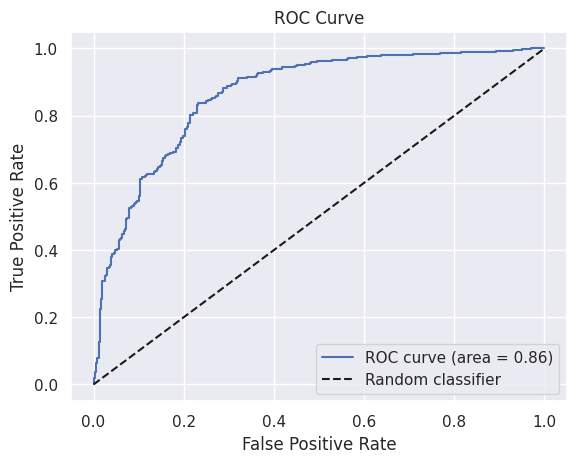

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()